# 1. Подготовка среды

Описание подготовки среды в README, здесь лишь проверим что Spark-сессия корректно запускается.

In [1]:
import pyspark
print(pyspark.__version__)

4.0.1


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("COVID19 X-Ray Analysis") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.port", "7077") \
    .getOrCreate()

df = spark.createDataFrame([(1, "test")], ["id", "value"])
df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/05 00:07:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+---+-----+
| id|value|
+---+-----+
|  1| test|
+---+-----+



# 2. Предобработка данных

In [3]:
df = spark.read.csv("metadata.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

Будем использовать поля:

- `patientid` (идентификатор пациента)
- `age` (возраст, есть не для всех записей)
- `sex` (пол, не для всех записей)
- `finding` (диагноз: COVID-19, Pneumonia, Normal и другие)
- `view` (проекция снимка: PA, AP и так далее)
- `date` (дата исследования)

In [4]:
df = df.select("patientid", "age", "sex", "finding", "view", "date")

In [5]:
df.show(10)

+---------+----+----+--------------------+----+----------------+
|patientid| age| sex|             finding|view|            date|
+---------+----+----+--------------------+----+----------------+
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 22, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 27, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 28, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 30, 2020|
|        5|NULL|NULL|           Pneumonia|  PA|            2017|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| January 6, 2020|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA|January 10, 2020|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
+---------+----+----+--------------------+----+----------------+
only showing top 10 rows


In [6]:
print("Всего записей в df:", df.count())

Всего записей в df: 950


Посчитаем пропуски в признаках

In [7]:
from pyspark.sql.functions import col, when, count

df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
|        0|237| 80|      0|   0| 289|
+---------+---+---+-------+----+----+



Заполним пропуски в возрасте медианой, в поле модой, а пропуски в дате заполнять не будем.

In [8]:
median_age = df.approxQuantile("age", [0.5], 0.01)[0]
mode_sex = df.groupBy("sex").count().orderBy("count", ascending=False).first()["sex"]

df = df.fillna({
    'age': median_age,
    'sex': mode_sex,
})

Унинифицируем диагнозы, для этого посмотрим какие бывают:

In [9]:
df.select("finding").distinct().show(100, truncate=False)

+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Aspiration                   |
|Pneumonia/Lipoid                       |
|Tuberculosis                           |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial                    |
|Pneumonia/Viral/MERS-CoV               |
|Unknown                                |
|Pneumonia/Viral/Varicella              |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Bacterial/Nocardia           |
|todo                                   |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Fungal/Aspergillosis         |
|Pneumonia/Viral/Herpes           

In [10]:
def unify_finding(finding):
    if finding is None:
        return "Unknown"
    f = finding.lower().strip()
    if "covid" in f:
        return "COVID-19"
    elif "sars" in f:
        return "SARS"
    elif "mers" in f:
        return "MERS"
    elif "influenza" in f or "h1n1" in f:
        return "Influenza"
    elif "tuberculosis" in f:
        return "Tuberculosis"
    elif "no finding" in f:
        return "Normal"
    elif "unknown" in f or "todo" in f:
        return "Unknown"
    elif "pneumonia/viral" in f:
        return "Pneumonia-Viral"
    elif "pneumonia/bacterial" in f:
        return "Pneumonia-Bacterial"
    elif "pneumonia/fungal" in f:
        return "Pneumonia-Fungal"
    elif "pneumonia" in f:
        return "Pneumonia"
    else:
        return "Other"

In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

unify_finding_udf = udf(unify_finding, StringType())
df = df.withColumn("finding", unify_finding_udf(col("finding")))

In [12]:
before = df.count()
df = df.dropDuplicates(["patientid", "date"])
after = df.count()
print(f"Удалено дубликатов: {before - after}")

Удалено дубликатов: 439


# 3. Анализ качества данных

Выявим и обработаем аномальные значения. Для возраста считаем валидными значения 0-123 лет, для пола значения 'M' и 'F', даты в диапозоне вируса ковида, то есть с декабря 2019 года и по настоящее время(декабрь 2025).

In [13]:
df.filter((col("age") < 0) | (col("age") > 120)).show()

[Stage 28:>                                                         (0 + 1) / 1]

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
+---------+---+---+-------+----+----+



In [14]:
df.filter(~col("sex").isin("M", "F")).show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
+---------+---+---+-------+----+----+



Чтобы работать с датой, а не со строкой, предварительно переведем столбец в другой тип, а для этого посмотрим в каком формате у нас дата.

In [15]:
df.select("date").distinct().show(100, truncate=False)

+------------------+
|date              |
+------------------+
|December 30, 2019 |
|2016              |
|2020              |
|2/29/2020         |
|September 16, 2009|
|February 4, 2020  |
|January 6, 2020   |
|January 28, 2020  |
|Oct 8, 2010       |
|2019              |
|2017              |
|2014              |
|2013              |
|December 29, 2019 |
|12 March 2020     |
|03/06/20          |
|May 4, 2010       |
|2018              |
|June 5, 2017      |
|Mar 5, 2020       |
|Feb 16, 2020      |
|January 1, 2020   |
|February 18, 2020 |
|March 5, 2020     |
|Mar 4, 2020       |
|January 26, 2020  |
|Feb 18, 2020      |
|Feb 21, 2020      |
|September 10, 2009|
|February 25, 2020 |
|September 21, 2009|
|January 12        |
|Feb 17, 2020      |
|March 10, 2020    |
|2004              |
|03/16/20          |
|January 20        |
|2011              |
|January 19, 2020  |
|Jan 28, 2020      |
|May 10, 2015      |
|January 23, 2020  |
|January 31, 2020  |
|December 27, 2019 |
|2007        

Очень разнообразный формат дат, будем использовать библиотеку python-dateutil

In [16]:
pip install python-dateutil

Note: you may need to restart the kernel to use updated packages.


In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType
from dateutil import parser

def parse_date_safe(s):
    if s is None:
        return None
    try:
        return parser.parse(s, fuzzy=True).date()
    except Exception:
        return None

parse_date_udf = udf(parse_date_safe, DateType())

df = df.withColumn("date_dt", parse_date_udf(df.date))

In [18]:
df.select("date_dt").distinct().show(100, truncate=False)

+----------+
|date_dt   |
+----------+
|2015-05-10|
|2020-03-07|
|2020-03-13|
|2020-02-04|
|2004-12-05|
|2010-05-04|
|2015-12-05|
|2020-01-25|
|2020-03-09|
|2020-03-10|
|2019-12-29|
|2020-02-25|
|2019-11-27|
|2020-04-06|
|2019-12-05|
|2020-02-21|
|2020-01-10|
|2020-03-03|
|2010-10-08|
|2020-02-27|
|2020-01-24|
|2009-09-21|
|2020-03-05|
|2020-03-06|
|2025-01-13|
|2003-03-05|
|2017-12-05|
|2020-02-01|
|2020-01-13|
|2020-01-28|
|2020-01-22|
|2025-01-12|
|2019-12-27|
|2019-02-26|
|2016-12-05|
|2011-12-05|
|2020-01-06|
|2019-05-09|
|2025-01-20|
|2018-12-05|
|2009-09-10|
|2020-02-05|
|2019-12-30|
|2020-01-27|
|2020-02-06|
|2020-03-12|
|2020-01-30|
|2009-09-16|
|2020-01-12|
|2020-03-16|
|2020-01-19|
|2020-02-18|
|2007-12-05|
|2020-02-29|
|2020-01-23|
|2013-12-05|
|2017-06-05|
|2020-01-31|
|2020-02-16|
|2020-01-26|
|2014-12-05|
|2020-01-20|
|2020-02-17|
|2020-01-01|
|2020-03-04|
|2020-02-02|
|2020-03-14|
|2010-12-05|
|2020-01-29|
|2020-12-05|
|NULL      |
+----------+



Теперь можно посмотреть аномальные даты

In [19]:
from pyspark.sql.functions import lit

df.filter(
    (df.date_dt < lit('2019-12-01')) | 
    (df.date_dt > lit('2025-12-31')) | 
    (df.date_dt.isNull())
).select("date", "date_dt").show(truncate=False)

+------------+----------+
|date        |date_dt   |
+------------+----------+
|2017        |2017-12-05|
|Oct 8, 2010 |2010-10-08|
|2015        |2015-12-05|
|June 5, 2017|2017-06-05|
|2014        |2014-12-05|
|2014        |2014-12-05|
|2015        |2015-12-05|
|2015        |2015-12-05|
|2016        |2016-12-05|
|2017        |2017-12-05|
|May 10, 2015|2015-05-10|
|2013        |2013-12-05|
|2016        |2016-12-05|
|2016        |2016-12-05|
|2016        |2016-12-05|
|May 4, 2010 |2010-05-04|
|2004        |2004-12-05|
|2010        |2010-12-05|
|2014        |2014-12-05|
|2011        |2011-12-05|
+------------+----------+
only showing top 20 rows


In [20]:
df = df.drop("date")
df = df.withColumnRenamed("date_dt", "date")

Аномальные значения только в признаке даты, удалим такие записи из df.

In [21]:
before = df.count()
df = df.filter(
    (df.date >= lit('2019-12-01')) & (df.date <= lit('2025-12-31'))
)
after = df.count()
print(f"Удалено аномалий: {before - after}")

Удалено аномалий: 184


# 4. SQL-аналитика

Перед выполнением запросов создадим временную таблицу:

In [22]:
df.createOrReplaceTempView("meta")

25/12/05 00:07:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Запрос 1. Базовая статистика по диагнозам.

In [23]:
spark.sql("""
    SELECT finding, COUNT(*) AS count
    FROM meta
    GROUP BY finding
    ORDER BY count DESC
""").show()

+-------------------+-----+
|            finding|count|
+-------------------+-----+
|           COVID-19|  291|
|            Unknown|   26|
|             Normal|    8|
|Pneumonia-Bacterial|    1|
|          Influenza|    1|
+-------------------+-----+



## Запрос 2. Распределение по полу и диагнозам.

In [24]:
spark.sql("""
    SELECT sex, finding, COUNT(*) AS count
    FROM meta
    GROUP BY sex, finding
    ORDER BY sex, count DESC
""").show()

+---+-------------------+-----+
|sex|            finding|count|
+---+-------------------+-----+
|  F|           COVID-19|   95|
|  F|            Unknown|    6|
|  F|             Normal|    4|
|  F|          Influenza|    1|
|  M|           COVID-19|  196|
|  M|            Unknown|   20|
|  M|             Normal|    4|
|  M|Pneumonia-Bacterial|    1|
+---+-------------------+-----+



## Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов).

In [25]:
spark.sql("""
    SELECT finding, age, sex, rn
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) as rn
        FROM meta
    )
    WHERE rn <= 3
    ORDER BY finding, age DESC
""").show()

+-------------------+---+---+---+
|            finding|age|sex| rn|
+-------------------+---+---+---+
|           COVID-19| 94|  M|  1|
|           COVID-19| 93|  F|  2|
|           COVID-19| 87|  M|  3|
|          Influenza| 60|  F|  1|
|             Normal| 78|  F|  1|
|             Normal| 78|  F|  2|
|             Normal| 75|  M|  3|
|Pneumonia-Bacterial| 52|  M|  1|
|            Unknown| 54|  M|  1|
|            Unknown| 54|  M|  2|
|            Unknown| 54|  M|  3|
+-------------------+---+---+---+



## Запрос 4. Анализ временных трендов по датам исследований.

In [26]:
spark.sql("""
    SELECT
        date_format(date, 'yyyy-MM') AS month,
        finding,
        COUNT(*) AS studies_count
    FROM meta
    GROUP BY month, finding
    ORDER BY month, finding
""").show()

+-------+-------------------+-------------+
|  month|            finding|studies_count|
+-------+-------------------+-------------+
|2019-12|           COVID-19|            4|
|2019-12|             Normal|            1|
|2020-01|           COVID-19|           26|
|2020-02|           COVID-19|           15|
|2020-03|           COVID-19|           23|
|2020-03|          Influenza|            1|
|2020-03|             Normal|            2|
|2020-03|Pneumonia-Bacterial|            1|
|2020-04|           COVID-19|            1|
|2020-12|           COVID-19|          219|
|2020-12|             Normal|            5|
|2020-12|            Unknown|           26|
|2025-01|           COVID-19|            3|
+-------+-------------------+-------------+



## Запрос 5. Статистика по проекциям снимков и их связи с диагнозами.

In [27]:
spark.sql("""
    SELECT view, finding, COUNT(*) AS count
    FROM meta
    GROUP BY view, finding
    ORDER BY view, count DESC
""").show()

+---------+-------------------+-----+
|     view|            finding|count|
+---------+-------------------+-----+
|       AP|           COVID-19|   77|
|       AP|             Normal|    2|
|       AP|          Influenza|    1|
|AP Supine|           COVID-19|   71|
|AP Supine|            Unknown|   18|
|AP Supine|             Normal|    1|
|    Axial|           COVID-19|   19|
|        L|           COVID-19|    1|
|       PA|           COVID-19|  123|
|       PA|            Unknown|    8|
|       PA|             Normal|    5|
|       PA|Pneumonia-Bacterial|    1|
+---------+-------------------+-----+



In [28]:
df.createOrReplaceTempView("meta")

# 1. Базовая статистика по диагнозам
spark.sql("SELECT finding, COUNT(*) as cnt FROM meta GROUP BY finding").show()

# 2. Распределение по полу и диагнозам
spark.sql("""
SELECT sex, finding, COUNT(*) as cnt
FROM meta
GROUP BY sex, finding
ORDER BY sex, cnt DESC
""").show()

# 3. Топ-3 по возрасту в каждой группе диагнозов (оконная функция)
spark.sql("""
SELECT *
FROM (
    SELECT *, ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) as rn
    FROM meta
)
WHERE rn <= 3
""").show()

# 4. Временные тренды
spark.sql("""
SELECT date, finding, COUNT(*) as cnt
FROM meta
GROUP BY date, finding
ORDER BY date
""").show()

# 5. Статистика по проекциям снимков и их связи с диагнозами
spark.sql("""
SELECT view, finding, COUNT(*) as cnt
FROM meta
GROUP BY view, finding
ORDER BY view, cnt DESC
""").show()

+-------------------+---+
|            finding|cnt|
+-------------------+---+
|Pneumonia-Bacterial|  1|
|            Unknown| 26|
|           COVID-19|291|
|          Influenza|  1|
|             Normal|  8|
+-------------------+---+

+---+-------------------+---+
|sex|            finding|cnt|
+---+-------------------+---+
|  F|           COVID-19| 95|
|  F|            Unknown|  6|
|  F|             Normal|  4|
|  F|          Influenza|  1|
|  M|           COVID-19|196|
|  M|            Unknown| 20|
|  M|             Normal|  4|
|  M|Pneumonia-Bacterial|  1|
+---+-------------------+---+

+---------+---+---+-------------------+---------+----------+---+
|patientid|age|sex|            finding|     view|      date| rn|
+---------+---+---+-------------------+---------+----------+---+
|     326b| 94|  M|           COVID-19|       AP|2020-12-05|  1|
|     324b| 93|  F|           COVID-19|       AP|2020-12-05|  2|
|       55| 87|  M|           COVID-19|       AP|2020-03-07|  3|
|      375| 60

# 5. Обработка в PySpark

Реализуем пользовательскую функцию для категоризации возраста

In [29]:
def age_group(age):
    if age < 18:
        return "Child(18-)"
    elif age < 40:
        return "Young Adult(18-39)"
    elif age < 60:
        return "Adult(40-59)"
    else:
        return "Senior(60+)"

In [30]:
age_group_udf = udf(age_group, StringType())
df = df.withColumn("age_group", age_group_udf(col("age")))
df.show(5)

+---------+---+---+--------+----+----------+------------+
|patientid|age|sex| finding|view|      date|   age_group|
+---------+---+---+--------+----+----------+------------+
|       11| 56|  M|COVID-19|  PA|2020-12-05|Adult(40-59)|
|      112| 54|  M|COVID-19|  PA|2020-12-05|Adult(40-59)|
|      113| 54|  M|COVID-19|  PA|2020-12-05|Adult(40-59)|
|      114| 54|  M|COVID-19|  PA|2020-12-05|Adult(40-59)|
|      115| 54|  M|COVID-19|  PA|2020-12-05|Adult(40-59)|
+---------+---+---+--------+----+----------+------------+
only showing top 5 rows


Сохраним результат в оптимизированном формате:

In [31]:
df.write.mode("overwrite").parquet("result_cleaned.parquet")

# 6. Визуализация

Поскольку у нас мало данных переведем Spark DataFrame в Pandas, потому что matplotlib/seaborn напрямую работают только с Pandas DataFrame 

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df.toPandas()

## Круговая диаграмма распределения диагнозов

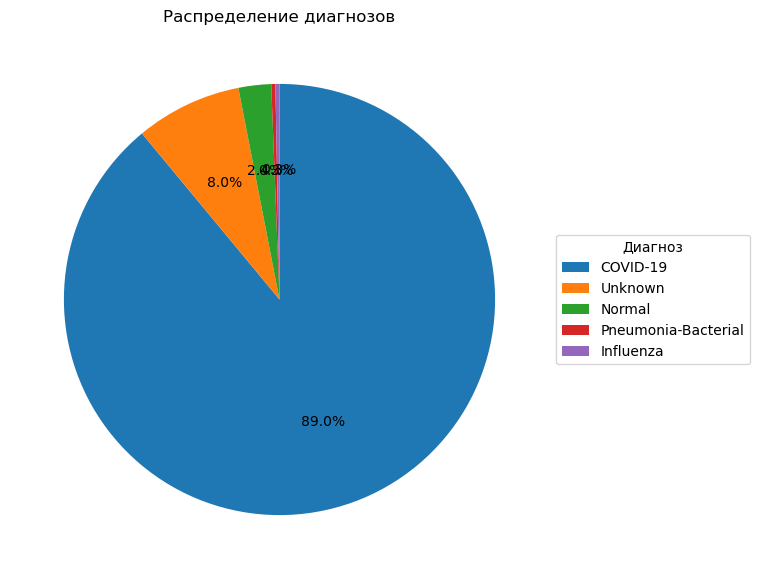

In [33]:
diag_counts = pdf['finding'].value_counts()
labels = diag_counts.index
sizes = diag_counts.values

fig, ax = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax.pie(
    sizes, labels=None, autopct='%1.1f%%', startangle=90, counterclock=False
)
ax.legend(wedges, labels, title="Диагноз", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Распределение диагнозов")
plt.ylabel("")
plt.show()

## Столбчатая диаграмма по возрастным группам

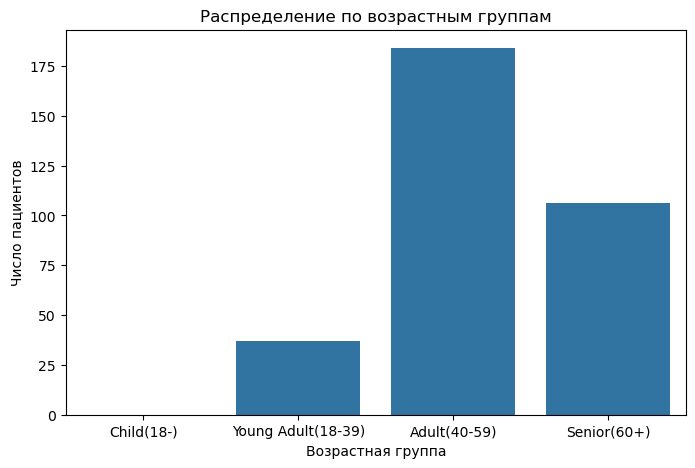

In [37]:
plt.figure(figsize=(8,5))
sns.countplot(data=pdf, x='age_group', order=['Child(18-)', 'Young Adult(18-39)', 'Adult(40-59)', 'Senior(60+)'])
plt.title("Распределение по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Число пациентов")
plt.show()

## График временных трендов исследований

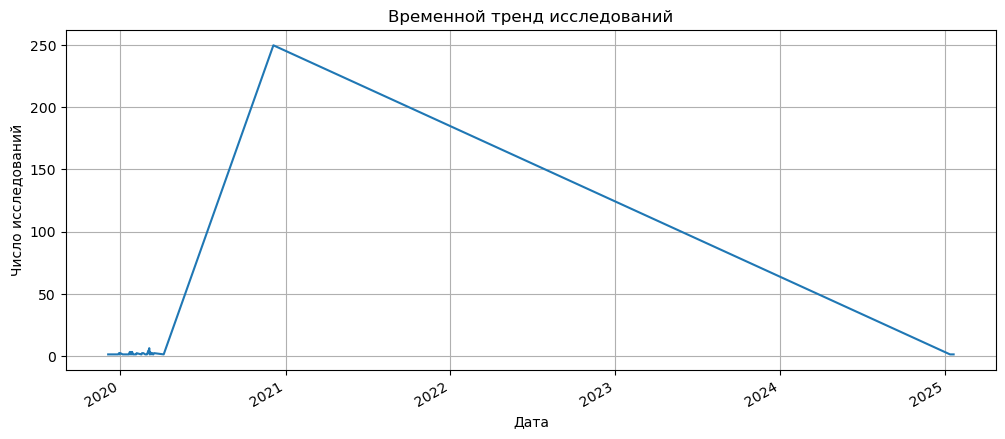

In [35]:
pdf['date'] = pd.to_datetime(pdf['date'], errors='coerce')
trend = pdf.groupby('date').size()

plt.figure(figsize=(12,5))
trend.plot()
plt.title("Временной тренд исследований")
plt.xlabel("Дата")
plt.ylabel("Число исследований")
plt.grid(True)
plt.show()

## Heatmap распределения диагнозов по проекциям снимков

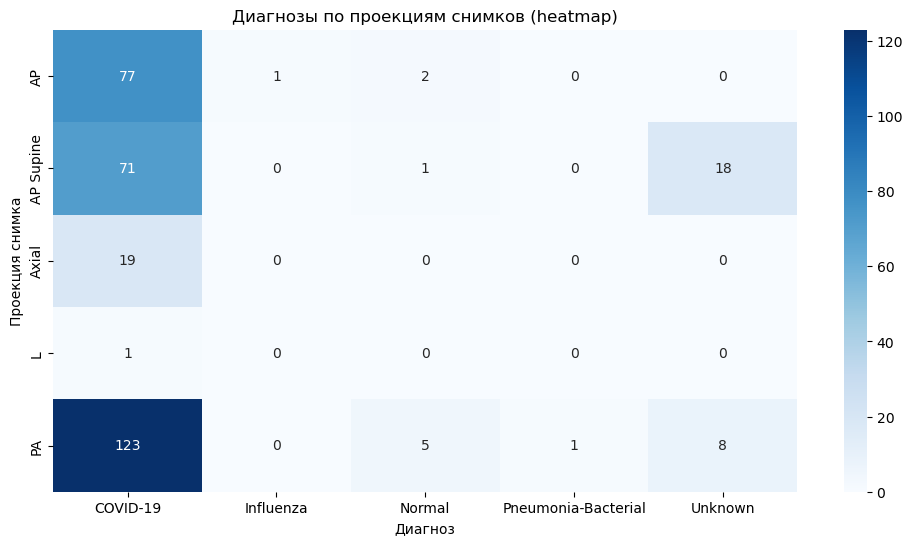

In [36]:
heatmap_data = pd.crosstab(pdf['view'], pdf['finding'])

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Диагнозы по проекциям снимков (heatmap)")
plt.xlabel("Диагноз")
plt.ylabel("Проекция снимка")
plt.show()